In [53]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from transformers import TrainingArguments, Trainer
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

In [54]:
train_file_path = "/kaggle/input/nlp-dataset/SP_train.npy"
eval_file_path = "/kaggle/input/nlp-dataset/SP_eval_data_for_practice.npy"

In [55]:
train_data = np.load(train_file_path ,allow_pickle = True)
eval_data = np.load(eval_file_path, allow_pickle = True)

In [56]:
train_texts = []
train_labels =[]

eval_texts = []

In [57]:
with open('/kaggle/input/val-labels/list.pkl', 'rb') as f:
    eval_labels = pickle.load(f)

In [58]:
for data in train_data:
  Q = data['question']

  X = '[CLS] ' + Q + ' [SEP] '

  for i in range(4):
    Y = X + data['choice_list'][i] + ' [SEP]'
    train_texts.append(Y)

    if data['choice_order'][i] == 0:
      train_labels.append(1)
    else:
      train_labels.append(0)

In [59]:
for data in eval_data:
  Q = data['question']

  X = '[CLS] ' + Q + ' [SEP] '

  for i in range(4):
    Y = X + data['choice_list'][i] + ' [SEP]'
    eval_texts.append(Y)

In [83]:
def evaluate(texts, labels, model):
    lst = [texts[i:i+4] for i in range(0, len(texts), 4)]
    labls = [labels[i:i+4] for i in range(0, len(labels), 4)]
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    preds = []
    orgs = []
    
    for i in range(len(lst)):

      ques = lst[i]
      labels2 = labls[i] 
        
      orgs.append(labels2.index(1))
      
      temp = []

      for q in ques:
        inputs = tokenizer(q, return_tensors="pt", padding=True, truncation=True)
        inputs.to(device)

        with torch.no_grad():
          outputs = model(**inputs)

          prob_dist = torch.softmax(outputs.logits, dim=1)
          prob = prob_dist[:, 1].item()

          temp.append(prob)

      array = np.array(temp)
      index_of_largest = np.argmax(array)

      preds.append(index_of_largest)
    
        
    accuracy = accuracy_score(preds, orgs)
    print("Accuracy: ", accuracy)

In [61]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Fine Tuning

In [62]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len=512)
eval_dataset = CustomDataset(eval_texts, eval_labels, tokenizer, max_len=512)

In [64]:
training_args = TrainingArguments(
    output_dir='/kaggle/working/',
    num_train_epochs=10,
    per_device_train_batch_size=1,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=2,
    evaluation_strategy = "epoch",
    logging_strategy = "epoch"
)

In [65]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [66]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,0.918100,0.739336
2,0.968400,0.939339
3,0.964800,1.042253
4,0.926700,0.956743
5,0.986400,0.937054
6,0.962100,0.907751
7,0.957800,0.999729
8,0.972400,0.970059
9,0.960600,0.909808
10,0.626100,0.853555


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=10140, training_loss=0.9243587516468658, metrics={'train_runtime': 2363.5591, 'train_samples_per_second': 8.58, 'train_steps_per_second': 4.29, 'total_flos': 5335892202700800.0, 'train_loss': 0.9243587516468658, 'epoch': 10.0})

# Evaluation

In [67]:
evaluate(train_texts, train_labels, model)

Accuracy:  0.8422090729783037


In [68]:
evaluate(eval_texts, eval_labels, model)

Accuracy:  0.7166666666666667


# Plots

In [71]:
training_losses = [0.918100, 0.968400, 0.964800, 0.926700,0.986400,0.962100,0.95780,0.972400,0.960600,0.626100]
validation_losses = [0.739336, 0.939339, 1.042253, 0.956743, 0.937054,0.907751, 0.999729, 0.970059, 0.909808, 0.853555 ]
epochs = [1,2,3,4,5, 6, 7 , 8, 9 , 10]

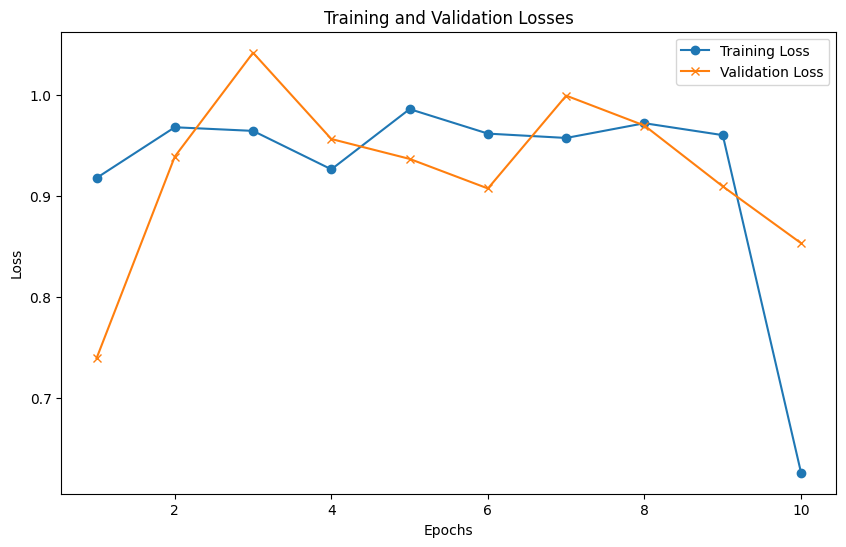

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, marker='o', label='Training Loss')
plt.plot(epochs, validation_losses, marker='x', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# plt.grid(True)
plt.show()

# Saving the Trained Model

In [73]:
torch.save(model.state_dict(), "/kaggle/working/bert-model-final.pt")

In [74]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pt_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Loading the saved model

In [79]:
pt_model.load_state_dict(torch.load("/kaggle/working/bert-model-final.pt"))

<All keys matched successfully>

In [84]:
evaluate(train_texts, train_labels, pt_model)

Accuracy:  0.8422090729783037


In [85]:
evaluate(eval_texts, eval_labels, pt_model)

Accuracy:  0.7166666666666667
